##### Import libraries and read in data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords


In [2]:
renewable=pd.read_csv('../data/renewable.csv')
non=pd.read_csv('../data/non_renewable.csv')

##### Rejoin datasets and add dummy variable to indicate subreddit (1 for Renewable Energy and 0 for Energy).

In [3]:
df=pd.concat([renewable, non], ignore_index=True)

In [4]:
df.tail(3)

,title,subreddit
1996,Lawn mower Battery Market: Industry Analysis a...,energy
1997,Gas Genset Market- Industry Analysis and forec...,energy
1998,Electric Rope Shovel Market- Industry Analysis...,energy


In [5]:
df['subreddit'].replace({'RenewableEnergy':1,'energy':0},inplace=True)

In [6]:
df.tail(3)

,title,subreddit
1996,Lawn mower Battery Market: Industry Analysis a...,0
1997,Gas Genset Market- Industry Analysis and forec...,0
1998,Electric Rope Shovel Market- Industry Analysis...,0


In [9]:
df.head(5)

,title,subreddit
0,baufinanzierung commerzbank – top konditionen ...,1
1,Solar Tsunami: Solar PV grows 26% again – stay...,1
2,Agrivolaics to shine in France after president...,1
3,Germany aims to get 100% of energy from renewa...,1
4,Selecting and Building Large-Scale Solar Racki...,1


##### Train/test split.

In [20]:
X=df['title']
y=df['subreddit']

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

##### Baseline model

In [22]:
y.value_counts(normalize=True)

1    0.50025
0    0.49975
Name: subreddit, dtype: float64

This rate of 50.025% is to be used as a comparison value in evaluating the performance of both production models.

##### Define lemmatize & stem functions

Approach sourced from NLP Breakfast Hour 2/28.

In [23]:
def lemmatize_review(review):
    lemmatizer = WordNetLemmatizer()
    split_review = review.split(' ')
    return [lemmatizer.lemmatize(word) for word in split_review]

In [24]:
def stem_review(review):
    p_stemmer = PorterStemmer()
    split_review = review.split(' ')
    return [p_stemmer.stem(word) for word in split_review]

### Logistic Regression Model

In [25]:
logpipe = Pipeline([
    ('vect', CountVectorizer()),
    ('log', LogisticRegression())
])

In [27]:
params = {
    'vect__min_df': (0,1,2),
    'vect__max_df': [1.0,.5],
    'vect__tokenizer': [stem_review, lemmatize_review, None],
    'vect__binary': [True, False],
    'vect__ngram_range':[(1,1),(1,2)],
    'log__solver':['lbfgs','liblinear'],
    'log__max_iter':[1000]
}

lgs = GridSearchCV(logpipe,param_grid=params)
lgs.fit(X_train, y_train)
print('Cross Val Score:', lgs.best_score_)
print('Train Score:', lgs.score(X_train, y_train))
print('Test Score:', lgs.score(X_test, y_test))
print('Best Parameters', lgs.best_params_)

Cross Val Score: 0.6897948717948716
Train Score: 0.9739826551034023
Test Score: 0.666
Best Parameters {'log__max_iter': 1000, 'log__solver': 'lbfgs', 'vect__binary': True, 'vect__max_df': 1.0, 'vect__min_df': 0, 'vect__ngram_range': (1, 2), 'vect__tokenizer': <function stem_review at 0x11dae6c10>}


### Random Forest Model

In [90]:
rfpipe = Pipeline([
    ('vect', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

In [97]:
params = {
    'vect__min_df': (0,1,2),
    'vect__max_df': [1.0,.5],
    'vect__tokenizer': [stem_review, lemmatize_review, None],
    'vect__binary': [True, False],
    'vect__ngram_range':[(1,1),(1,2)],
    'rf__max_depth': [None, 3],
    'rf__max_features': ['auto', 3, 5]
}
gs = GridSearchCV(rfpipe,param_grid=params,verbose=0)
gs.fit(X_train, y_train)
print('Cross Val Score:', gs.best_score_)
print('Train Score:', gs.score(X_train, y_train))
print('Test Score:', gs.score(X_test, y_test))
print('Best Parameters', gs.best_params_)

Cross Val Score: 0.7011282051282052
Train Score: 0.9733155436957972
Test Score: 0.682
Best Parameters {'rf__max_depth': None, 'rf__max_features': 'auto', 'vect__binary': False, 'vect__max_df': 1.0, 'vect__min_df': 2, 'vect__ngram_range': (1, 2), 'vect__tokenizer': <function stem_review at 0x11f91baf0>}


### Model Evaluation

From the cross val scores above, we can see that the Random Forest model performs slightly better than the Logistic Regression model.

##### Classification Report

In [28]:
# Logisitic Regression
print(metrics.classification_report(y_test,lgs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       239
           1       0.70      0.64      0.67       261

    accuracy                           0.67       500
   macro avg       0.67      0.67      0.67       500
weighted avg       0.67      0.67      0.67       500



In [122]:
# Random Forest
print(metrics.classification_report(y_test,gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       239
           1       0.71      0.66      0.69       261

    accuracy                           0.68       500
   macro avg       0.68      0.68      0.68       500
weighted avg       0.68      0.68      0.68       500



The better performance of the Random Forest model is reinforced with a slightly higher accuracy rate and f1-scores, though they are comparable between the two.

##### Confusion Matrix

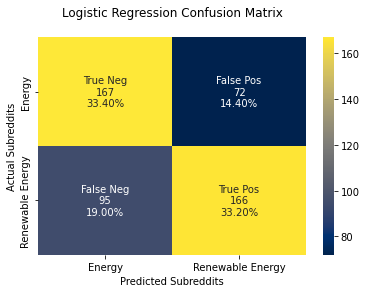

In [136]:
# Resource on plotting from Ben Roberts - https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
preds = lgs.predict(X_test)

cf_matrix = confusion_matrix(y_test,lgs.predict(X_test))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='cividis')
ax.set_title('Logistic Regression Confusion Matrix\n');
ax.set_xlabel('Predicted Subreddits')
ax.set_ylabel('Actual Subreddits')
ax.xaxis.set_ticklabels(['Energy','Renewable Energy'])
ax.yaxis.set_ticklabels(['Energy','Renewable Energy']);


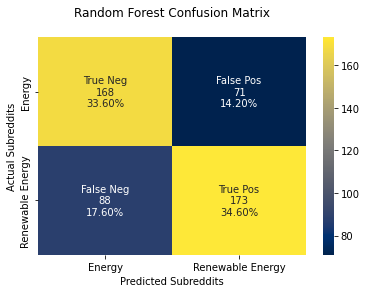

In [137]:
# Same resource on plotting from Ben Roberts - https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
preds = gs.predict(X_test)

cf_matrix = confusion_matrix(y_test,gs.predict(X_test))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='cividis')
ax.set_title('Random Forest Confusion Matrix\n');
ax.set_xlabel('Predicted Subreddits')
ax.set_ylabel('Actual Subreddits')
ax.xaxis.set_ticklabels(['Energy','Renewable Energy'])
ax.yaxis.set_ticklabels(['Energy','Renewable Energy']);


As expected from the classification report, the Random Forest model has slightly fewer false negatives (88 vs 95) and false positives (71 vs 72) than the Logisitic Regression model. Again, both are very close.

The percentage of observations incorrectly predicted do not reflect a high level of accuracy. This could be due to needing a different model or further refining the current model, or may be a reflection of overlap in the subreddits.

##### Sensitivity vs Specificity

In [156]:
# Logistic Regression
# Approach sourced from Classification Metrics II lesson 2/16
pred_df=pd.DataFrame({'true_values':y_test,
                      'pred_probs':lgs.predict_proba(X_test)[:,1]})

pred_df.head()

,true_values,pred_probs
256,1,0.417522
352,1,0.008026
298,1,0.605801
581,1,0.935339
1288,0,0.406054


In [165]:
for group in pred_df.groupby('true_values'):
    print(group[1])

      true_values  pred_probs
1288            0    0.406054
1765            0    0.005830
1587            0    0.816226
1611            0    0.118037
1997            0    0.036482
...           ...         ...
1237            0    0.545880
1355            0    0.951894
1613            0    0.114303
1553            0    0.818563
1682            0    0.018249

[239 rows x 2 columns]
     true_values  pred_probs
256            1    0.417522
352            1    0.008026
298            1    0.605801
581            1    0.935339
420            1    0.849010
..           ...         ...
425            1    0.938279
530            1    0.923230
408            1    0.581090
692            1    0.637134
931            1    0.892905

[261 rows x 2 columns]


/Users/Suzanne/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


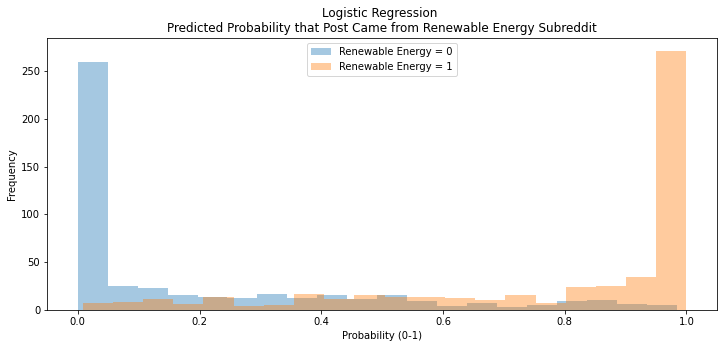

In [149]:
plt.figure(figsize = (12, 5))
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Renewable Energy = {group[0]}')

plt.title('Logistic Regression \nPredicted Probability that Post Came from Renewable Energy Subreddit')
plt.xlabel('Probability (0-1)')
plt.ylabel('Frequency')
plt.legend();

In [150]:
# Random Forest
pred_df=pd.DataFrame({'true_values':y_test,
                      'pred_probs':gs.predict_proba(X_test)[:,1]})

pred_df.head()

,true_values,pred_probs
256,1,0.138770
352,1,0.240000
298,1,0.807500
581,1,0.874416
1288,0,0.625000


/Users/Suzanne/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


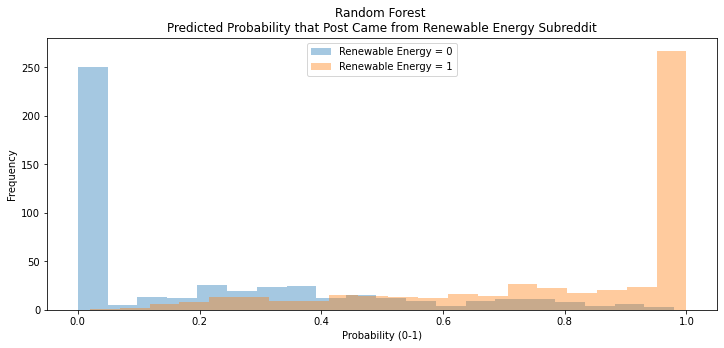

In [151]:
plt.figure(figsize = (12, 5))
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Renewable Energy = {group[0]}')

plt.title('Random Forest \nPredicted Probability that Post Came from Renewable Energy Subreddit')
plt.xlabel('Probability (0-1)')
plt.ylabel('Frequency')
plt.legend();

The broad distribution of probabilities indicates that altering either model's sensitivity rate would not necessarily result in a higher performance. It is difficult to successfully seperate the two subreddits with this level of overlap.

##### ROC Curve

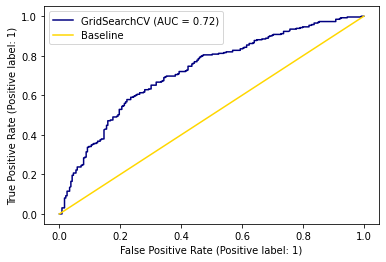

In [155]:
metrics.plot_roc_curve(lgs, X_test, y_test,color='navy')
plt.plot([0,1], [0,1], color='gold', label='Baseline')
plt.legend();

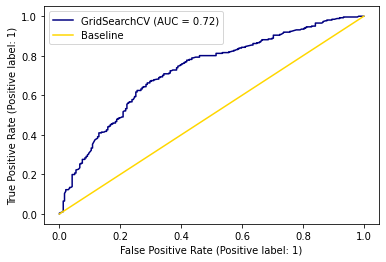

In [154]:
metrics.plot_roc_curve(gs, X_test, y_test,color='navy')
plt.plot([0,1], [0,1], color='gold', label='Baseline')
plt.legend();

These ROC curves again indicate a somewhat low level of model performance, though both are still above baseline accuracy.